In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


# Dublin Prediction

In [2]:
# new file containing rows with our focused area of Dublin found through exploratory analysis
irl = pd.read_csv('initial-ml-test-dub-1.csv', index_col='Unnamed: 0')

In [3]:
irl.head()

,Address,County,Price (€),VAT Exclusive,UsedProperty,Property Size Description,Year,Month,Town,Apartment,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",Dublin,447200.00,0,0,1,2014,1,Terenure,0,...,7.541595,0.492120,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.427900,3.568079
207905,"Number 7 Belfort House, Sydenham Villas, Dundrum",Dublin,398000.00,1,1,0,2014,1,Dundrum Dublin,0,...,6.817210,0.100996,2.784711,0.274841,0.831639,7.118560,3.635958,14.874822,5.905557,0.255856
207916,"Apartment 16 Cedar Grove, Firhouse Road, Templ...",Dublin,196035.24,0,0,1,2014,1,Templeogue,1,...,7.799393,0.683556,3.098765,3.760897,0.968202,7.197697,3.879724,17.923987,6.179356,3.002563
207925,"75 Palmerstown Avenue, Palmerstown",Dublin,95000.00,1,1,1,2014,1,Palmerstown,0,...,8.400802,0.319564,1.909348,3.576775,0.262801,7.051363,3.811554,18.189754,6.208934,1.206681
207929,"17 Churchview Apts, Church Rd, Drumcondra",Dublin,152000.00,1,1,2,2014,1,Drumcondra,1,...,2.225835,0.085034,0.909828,1.942439,0.597393,1.805008,0.902578,10.897507,1.587952,1.815296


In [4]:
#irl['Apartment'] = irl['Apartment'].fillna(0.0)

In [5]:
#irl['Property Size Description'].value_counts()

In [6]:
irl.shape

(5386, 25)

In [7]:
#irl.replace({'Property Size Description':{0:'38', 1:'75', 2: '125'}}, inplace = True)

In [8]:
#irl.head()

In [9]:
#y = pd.get_dummies(irl['Property Size Description'], prefix = 'Size')
#y.head()

In [10]:
#irl = irl.join(y)
#irl.drop(columns = ['Property Size Description'], inplace = True)
#irl.head()

In [11]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [12]:
irl.drop(columns=['VAT Exclusive'], inplace=True)
irl.head()

,Address,County,Price (€),UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",Dublin,447200.00,0,1,2014,1,Terenure,0,College Square Terenure,...,7.541595,0.492120,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.427900,3.568079
207905,"Number 7 Belfort House, Sydenham Villas, Dundrum",Dublin,398000.00,1,0,2014,1,Dundrum Dublin,0,Sydenham Villas Dundrum Dublin,...,6.817210,0.100996,2.784711,0.274841,0.831639,7.118560,3.635958,14.874822,5.905557,0.255856
207916,"Apartment 16 Cedar Grove, Firhouse Road, Templ...",Dublin,196035.24,0,1,2014,1,Templeogue,1,Firhouse Road Templeogue,...,7.799393,0.683556,3.098765,3.760897,0.968202,7.197697,3.879724,17.923987,6.179356,3.002563
207925,"75 Palmerstown Avenue, Palmerstown",Dublin,95000.00,1,1,2014,1,Palmerstown,0,Palmerstown Avenue Palmerstown,...,8.400802,0.319564,1.909348,3.576775,0.262801,7.051363,3.811554,18.189754,6.208934,1.206681
207929,"17 Churchview Apts, Church Rd, Drumcondra",Dublin,152000.00,1,2,2014,1,Drumcondra,1,Church Road Drumcondra,...,2.225835,0.085034,0.909828,1.942439,0.597393,1.805008,0.902578,10.897507,1.587952,1.815296


In [13]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [14]:
irl.head(1)

,Address,County,Price (€),UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",Dublin,447200.0,0,1,2014,1,428603.796167,0,College Square Terenure,...,7.541595,0.49212,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.4279,3.568079


In [15]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [16]:
irl['Neighbourhood'] = irl['Neighbourhood'].round()

In [17]:
encoder = TargetEncoder()
irl['Eircode'] = encoder.fit_transform(irl['Eircode'], irl['Price (€)'])

In [18]:
irl.head()

,Address,County,Price (€),UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",Dublin,447200.00,0,1,2014,1,428603.796167,0,595093.0,...,7.541595,0.492120,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.427900,3.568079
207905,"Number 7 Belfort House, Sydenham Villas, Dundrum",Dublin,398000.00,1,0,2014,1,499010.652149,0,1120920.0,...,6.817210,0.100996,2.784711,0.274841,0.831639,7.118560,3.635958,14.874822,5.905557,0.255856
207916,"Apartment 16 Cedar Grove, Firhouse Road, Templ...",Dublin,196035.24,0,1,2014,1,564023.918947,1,436254.0,...,7.799393,0.683556,3.098765,3.760897,0.968202,7.197697,3.879724,17.923987,6.179356,3.002563
207925,"75 Palmerstown Avenue, Palmerstown",Dublin,95000.00,1,1,2014,1,319537.941091,0,231951.0,...,8.400802,0.319564,1.909348,3.576775,0.262801,7.051363,3.811554,18.189754,6.208934,1.206681
207929,"17 Churchview Apts, Church Rd, Drumcondra",Dublin,152000.00,1,2,2014,1,428629.688519,1,172844.0,...,2.225835,0.085034,0.909828,1.942439,0.597393,1.805008,0.902578,10.897507,1.587952,1.815296


In [19]:
irl['LogPrice (€)'] = np.log(irl['Price (€)'])

In [20]:
irl = irl[['UsedProperty', 'Property Size Description', 'Year', 'Month', 'Town', 'Apartment', 'Neighbourhood',
'Eircode', 'Latitude', 'Longitude', 'DistanceIFSC', 'DistanceSchool', 'DistancePark', 'DistanceSecSchool', 'LogPrice (€)']]

In [21]:
irl.shape

(5386, 15)

In [22]:
irl.head(1)

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
207901,0,1,2014,1,428603.796167,0,595093.0,454593.5167,53.307878,-6.335665,7.541595,0.49212,1.438826,0.156609,13.010761


In [23]:
#irl.to_csv('sub-dub-encoded.csv')

In [24]:
#from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
#encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
#encoder_df = pd.DataFrame(encoder.fit_transform(irl[['Property Size Description']]).toarray())
#merge one-hot encoded columns back with original DataFrame
#irl1 = irl.join(encoder_df)

In [25]:
irl

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
207901,0,1,2014,1,428603.796167,0,595093.0,454593.516700,53.307878,-6.335665,7.541595,0.492120,1.438826,0.156609,13.010761
207905,1,0,2014,1,499010.652149,0,1120920.0,499010.652149,53.288227,-6.238896,6.817210,0.100996,2.784711,0.831639,12.894207
207916,0,1,2014,1,564023.918947,1,436254.0,454593.516700,53.291600,-6.312400,7.799393,0.683556,3.098765,0.968202,12.186050
207925,1,1,2014,1,319537.941091,0,231951.0,317917.959890,53.353853,-6.372213,8.400802,0.319564,1.909348,0.262801,11.461632
207929,1,2,2014,1,428629.688519,1,172844.0,305517.216068,53.366311,-6.263792,2.225835,0.085034,0.909828,0.597393,11.931636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261963,1,2,2021,10,352686.083110,0,453286.0,352686.083110,53.491883,-6.135906,17.439163,0.099830,9.753778,1.238197,12.936154
261968,0,2,2021,11,457655.376615,0,521558.0,606528.822301,53.255027,-6.147053,12.378025,0.892319,1.511927,1.557293,13.169684
262028,1,2,2021,12,202056.464897,0,195967.0,202056.464897,53.318052,-6.372816,9.121749,1.230371,2.045147,1.054941,12.542545
262032,1,2,2021,10,855537.184541,0,971920.0,606528.822301,53.282730,-6.119818,11.182747,0.468291,2.346736,0.672380,14.022525


In [26]:
x = irl.loc[:, irl.columns != 'LogPrice (€)']
y = irl['LogPrice (€)']

### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [27]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [28]:
specific21[specific21['Year'] == 2021].head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
218206,0,2,2021,4,309384.780408,0,324910.0,309384.780408,53.287576,-6.433316,14.222797,0.465772,6.634032,2.349923,12.624668
218208,0,2,2021,4,309384.780408,0,324910.0,309384.780408,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.747268
218210,0,2,2021,4,312355.752585,0,299528.0,264202.822368,53.397993,-6.127101,9.553714,0.383226,1.822449,0.258992,13.072690
218212,0,2,2021,4,278522.290224,0,312057.0,264202.822368,53.404602,-6.154503,8.626190,0.776872,0.417361,0.603363,12.797276
218221,0,2,2021,4,309384.780408,0,324910.0,309384.780408,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.653239


In [29]:
specific21.shape[0]

2817

In [30]:
train_21 = specific21[specific21['Year'] < 2021]

In [31]:
#train_21 = train_21.sample(n = 80000)
train_21.head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
212799,0,1,2019,1,282447.080721,0,280196.0,282447.080721,53.341446,-6.466279,14.658324,0.728724,5.931732,1.457938,12.639056
212801,0,1,2019,1,282447.080721,0,280196.0,282447.080721,53.341855,-6.465382,14.596166,0.735245,5.876450,1.383995,12.708047
212807,0,1,2019,1,267427.250302,0,251823.0,267427.250302,53.377230,-6.328681,6.307048,1.215076,0.323427,1.359171,12.681020
212810,0,1,2019,1,278522.290224,0,312057.0,264202.822368,53.404602,-6.154503,8.626190,0.776872,0.417361,0.603363,12.772587
212814,0,1,2019,1,282447.080721,0,280196.0,282447.080721,53.341448,-6.466043,14.642740,0.719977,5.916202,1.444132,12.484904


In [32]:
test_21 = specific21[specific21['Year'] == 2021]

In [33]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [34]:
#x_train_21.drop(columns=['Year'], inplace = True)

In [35]:
#test_21 = test_21.sample(n = 15000)
test_21.head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
218206,0,2,2021,4,309384.780408,0,324910.0,309384.780408,53.287576,-6.433316,14.222797,0.465772,6.634032,2.349923,12.624668
218208,0,2,2021,4,309384.780408,0,324910.0,309384.780408,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.747268
218210,0,2,2021,4,312355.752585,0,299528.0,264202.822368,53.397993,-6.127101,9.553714,0.383226,1.822449,0.258992,13.072690
218212,0,2,2021,4,278522.290224,0,312057.0,264202.822368,53.404602,-6.154503,8.626190,0.776872,0.417361,0.603363,12.797276
218221,0,2,2021,4,309384.780408,0,324910.0,309384.780408,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.653239


In [36]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [37]:
## explain_level gives information on feature importance when given value 1 or 2
automl1 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl1.fit(x_train_21, y_train_21)

AutoML directory: AutoML_6
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.43894 trained in 0.39 seconds
2_DecisionTree rmse 0.26055 trained in 23.63 seconds
3_Linear rmse 0.26323 trained in 3.49 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.226704 trained in 6.36 seconds
5_Default_NeuralNetwork rmse 0.243329 trained in 0.89 seconds
6_Default_RandomForest rmse 0.240805 trained in 5.49 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.223467 trained in 0.73 seconds
AutoML fit time: 56.11 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [38]:
# calculated values
y_predicted_21 = automl1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
#mse = mean_squared_error(y_test_21, y_predicted_21)
#print('MSE for AutoML 2021 is: ' + str(mse))

In [39]:
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_predicted_21))
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 29771510254.69321


In [40]:
rmse = mean_squared_error(np.exp(y_test_21), np.exp(y_predicted_21), squared = False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 172544.22695266627


In [41]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.48223350253807107


In [42]:
acc1 = accuracy_threshold(y_test_21, y_predicted_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6835871404399323


In [43]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_predicted_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

39304.30311429361


In [44]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_predicted_21))
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.2032554540233951


In [45]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [46]:
#cnames = ['Actual', 'Predicted']
#dfreal1 = pd.DataFrame(columns = cnames)
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020 predictions

In [47]:
specific20 = irl[irl['Year'] > 2016]

In [48]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [49]:
#train_20 = train_20.sample(n = 75000)

In [50]:
x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

In [51]:
x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [52]:
automl2 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl2.fit(x_train_20, y_train_20)

AutoML directory: AutoML_7
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.429639 trained in 0.76 seconds
2_DecisionTree rmse 0.268074 trained in 5.27 seconds
3_Linear rmse 0.273629 trained in 3.78 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.242796 trained in 5.05 seconds
5_Default_NeuralNetwork rmse 0.255719 trained in 1.48 seconds
6_Default_RandomForest rmse 0.253271 trained in 5.97 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.240391 trained in 0.68 seconds
AutoML fit time: 36.64 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [53]:
# calculated values
y_predicted_20 = automl2.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_predicted_20))
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 12300729690.687574


In [54]:
rmse = mean_squared_error(np.exp(y_test_20), np.exp(y_predicted_20), squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 110908.65471498415


In [55]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.5470494417862839


In [56]:
acc1 = accuracy_threshold(y_test_20, y_predicted_20, 0.2)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.7511961722488039


In [57]:
print("Median Absolute Error:\n")
print(median_absolute_error(np.exp(y_test_20), np.exp(y_predicted_20)))

Median Absolute Error:

31781.987300972105


In [58]:
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_predicted_20))
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.17384899088652886


In [59]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

In [60]:
x_test_20

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool
0,1,1,2020,1,312355.752585,0,299528.0,264202.822368,53.401554,-6.142369,8.987333,0.872126,0.966110,0.973263
1,1,1,2020,1,311810.468117,1,299401.0,311810.468117,53.278220,-6.215623,8.165170,0.671500,4.581569,0.367361
2,0,1,2020,1,309384.780408,0,325250.0,309384.780408,53.287170,-6.433778,14.271496,0.411923,6.688568,2.360507
3,1,1,2020,1,189697.120035,0,186260.0,305517.216068,53.400412,-6.257995,5.729754,0.356385,0.348535,0.468681
4,0,1,2020,1,352686.083110,0,378428.0,352686.083110,53.481426,-6.152438,15.933497,0.984305,8.469886,2.690280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,1,2,2020,11,282447.080721,0,309451.0,282447.080721,53.337031,-6.456940,14.079730,0.180497,5.290860,1.356490
623,0,2,2020,12,457655.376615,0,521558.0,606528.822301,53.255027,-6.147053,12.378025,0.892319,1.511927,1.557293
624,1,2,2020,12,855537.184541,0,1206630.0,606528.822301,53.284876,-6.117710,11.132583,0.472011,2.611803,0.622215
625,1,2,2020,11,383515.151515,0,395393.0,606528.822301,53.245058,-6.135482,13.726257,0.664591,2.711751,0.477108


In [61]:
#cnames = ['Actual', 'Predicted']
#dfreal2 = pd.DataFrame(columns = cnames)
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)
#dfreal2 = pd.concat([z1, z2], ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [62]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [63]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [64]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_pred_21))
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 29825207331.667313


In [65]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4263959390862944


In [66]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6903553299492385


In [67]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

47041.71171762794


In [68]:
mean = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

172699.7606589752


In [69]:
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_pred_21))
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.2059108173358727


In [70]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [71]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [72]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_pred_20))
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 21164686021.361855


In [73]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.37161084529505584


In [74]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.15)
print('Accuracy of properties at +- 15% of actual prices is ' + str(acc1))

Accuracy of properties at +- 15% of actual prices is 0.5518341307814992


In [75]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

45334.253354216984


In [76]:
mean = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

145480.87854203334


In [77]:
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_pred_20))
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.232926861170375


In [78]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [79]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [80]:
model = AdaBoostRegressor()

In [81]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [82]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_pred_21))
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 39134898626.176506


In [83]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.32656514382402707


In [84]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.5516074450084603


In [85]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

63613.45727088518


In [86]:
mean = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

197825.42462023548


In [87]:
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_pred_21))
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.2463869031864595


In [88]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [89]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [90]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_pred_20))
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 15358422784.811104


In [91]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.38596491228070173


In [92]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6874003189792663


In [93]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

45584.375329769624


In [94]:
mean = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

123929.10386511771


In [95]:
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_pred_20))
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.19753761157663932


In [96]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns = cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [97]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [98]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [99]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_pred_20))
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 12665425253.73137


In [100]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.5055821371610846


In [101]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.773524720893142


In [102]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

32830.89336950239


In [103]:
mean = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

112540.77151739883


In [104]:
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_pred_20))
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.17490487511304983


In [105]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [106]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [107]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_pred_21))
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 29250980992.536755


In [108]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.45346869712351945


In [109]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6615905245346869


In [110]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

42635.44058533083


In [111]:
mean = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

171029.18169872876


In [112]:
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_pred_21))
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.2087435142988245


In [113]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [114]:
from catboost import CatBoostRegressor

In [115]:
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.046461
0:	learn: 0.4099369	total: 184ms	remaining: 3m 3s
1:	learn: 0.3999737	total: 193ms	remaining: 1m 36s
2:	learn: 0.3896078	total: 199ms	remaining: 1m 6s
3:	learn: 0.3803211	total: 204ms	remaining: 50.8s
4:	learn: 0.3713867	total: 210ms	remaining: 41.7s
5:	learn: 0.3635104	total: 215ms	remaining: 35.6s
6:	learn: 0.3554932	total: 220ms	remaining: 31.2s
7:	learn: 0.3482736	total: 223ms	remaining: 27.7s
8:	learn: 0.3412203	total: 227ms	remaining: 24.9s
9:	learn: 0.3342177	total: 230ms	remaining: 22.7s
10:	learn: 0.3282276	total: 233ms	remaining: 20.9s
11:	learn: 0.3223272	total: 236ms	remaining: 19.4s
12:	learn: 0.3165782	total: 239ms	remaining: 18.1s
13:	learn: 0.3113449	total: 242ms	remaining: 17s
14:	learn: 0.3066314	total: 245ms	remaining: 16.1s
15:	learn: 0.3017377	total: 248ms	remaining: 15.2s
16:	learn: 0.2971600	total: 251ms	remaining: 14.5s
17:	learn: 0.2925466	total: 254ms	remaining: 13.8s
18:	learn: 0.2887128	total: 257ms	remaining: 13.3s
19:	learn: 0

181:	learn: 0.1924468	total: 867ms	remaining: 3.9s
182:	learn: 0.1922002	total: 871ms	remaining: 3.89s
183:	learn: 0.1920205	total: 884ms	remaining: 3.92s
184:	learn: 0.1917496	total: 889ms	remaining: 3.92s
185:	learn: 0.1915639	total: 896ms	remaining: 3.92s
186:	learn: 0.1914184	total: 901ms	remaining: 3.92s
187:	learn: 0.1913587	total: 906ms	remaining: 3.91s
188:	learn: 0.1912430	total: 910ms	remaining: 3.9s
189:	learn: 0.1911375	total: 915ms	remaining: 3.9s
190:	learn: 0.1909599	total: 919ms	remaining: 3.89s
191:	learn: 0.1907780	total: 923ms	remaining: 3.88s
192:	learn: 0.1906663	total: 931ms	remaining: 3.89s
193:	learn: 0.1905419	total: 936ms	remaining: 3.89s
194:	learn: 0.1903437	total: 939ms	remaining: 3.88s
195:	learn: 0.1902295	total: 943ms	remaining: 3.87s
196:	learn: 0.1900656	total: 949ms	remaining: 3.87s
197:	learn: 0.1899259	total: 952ms	remaining: 3.86s
198:	learn: 0.1897619	total: 956ms	remaining: 3.85s
199:	learn: 0.1896938	total: 960ms	remaining: 3.84s
200:	learn: 0.1

352:	learn: 0.1695443	total: 1.57s	remaining: 2.88s
353:	learn: 0.1693418	total: 1.58s	remaining: 2.89s
354:	learn: 0.1691450	total: 1.59s	remaining: 2.89s
355:	learn: 0.1690317	total: 1.6s	remaining: 2.89s
356:	learn: 0.1689940	total: 1.61s	remaining: 2.9s
357:	learn: 0.1689687	total: 1.61s	remaining: 2.9s
358:	learn: 0.1688558	total: 1.62s	remaining: 2.9s
359:	learn: 0.1686011	total: 1.63s	remaining: 2.89s
360:	learn: 0.1684738	total: 1.64s	remaining: 2.9s
361:	learn: 0.1684473	total: 1.64s	remaining: 2.89s
362:	learn: 0.1682602	total: 1.65s	remaining: 2.9s
363:	learn: 0.1680732	total: 1.66s	remaining: 2.9s
364:	learn: 0.1678868	total: 1.67s	remaining: 2.9s
365:	learn: 0.1676685	total: 1.68s	remaining: 2.9s
366:	learn: 0.1676402	total: 1.68s	remaining: 2.9s
367:	learn: 0.1675899	total: 1.69s	remaining: 2.9s
368:	learn: 0.1674158	total: 1.7s	remaining: 2.9s
369:	learn: 0.1673206	total: 1.7s	remaining: 2.9s
370:	learn: 0.1672718	total: 1.71s	remaining: 2.9s
371:	learn: 0.1671428	total:

517:	learn: 0.1515493	total: 2.25s	remaining: 2.1s
518:	learn: 0.1514406	total: 2.26s	remaining: 2.09s
519:	learn: 0.1513869	total: 2.26s	remaining: 2.09s
520:	learn: 0.1512812	total: 2.27s	remaining: 2.08s
521:	learn: 0.1511172	total: 2.27s	remaining: 2.08s
522:	learn: 0.1509873	total: 2.27s	remaining: 2.07s
523:	learn: 0.1508367	total: 2.28s	remaining: 2.07s
524:	learn: 0.1506500	total: 2.28s	remaining: 2.06s
525:	learn: 0.1506141	total: 2.28s	remaining: 2.06s
526:	learn: 0.1504669	total: 2.29s	remaining: 2.05s
527:	learn: 0.1502645	total: 2.29s	remaining: 2.05s
528:	learn: 0.1501213	total: 2.29s	remaining: 2.04s
529:	learn: 0.1500436	total: 2.3s	remaining: 2.04s
530:	learn: 0.1500300	total: 2.3s	remaining: 2.03s
531:	learn: 0.1499226	total: 2.3s	remaining: 2.03s
532:	learn: 0.1498892	total: 2.31s	remaining: 2.02s
533:	learn: 0.1498751	total: 2.31s	remaining: 2.01s
534:	learn: 0.1498307	total: 2.31s	remaining: 2.01s
535:	learn: 0.1498165	total: 2.31s	remaining: 2s
536:	learn: 0.14970

681:	learn: 0.1366112	total: 2.77s	remaining: 1.29s
682:	learn: 0.1365873	total: 2.77s	remaining: 1.29s
683:	learn: 0.1365024	total: 2.78s	remaining: 1.28s
684:	learn: 0.1364426	total: 2.78s	remaining: 1.28s
685:	learn: 0.1364064	total: 2.78s	remaining: 1.27s
686:	learn: 0.1363508	total: 2.79s	remaining: 1.27s
687:	learn: 0.1363270	total: 2.79s	remaining: 1.26s
688:	learn: 0.1362919	total: 2.79s	remaining: 1.26s
689:	learn: 0.1361089	total: 2.8s	remaining: 1.26s
690:	learn: 0.1360853	total: 2.8s	remaining: 1.25s
691:	learn: 0.1360405	total: 2.8s	remaining: 1.25s
692:	learn: 0.1359762	total: 2.81s	remaining: 1.24s
693:	learn: 0.1359276	total: 2.81s	remaining: 1.24s
694:	learn: 0.1358604	total: 2.82s	remaining: 1.24s
695:	learn: 0.1357455	total: 2.82s	remaining: 1.23s
696:	learn: 0.1356832	total: 2.83s	remaining: 1.23s
697:	learn: 0.1356061	total: 2.83s	remaining: 1.22s
698:	learn: 0.1355237	total: 2.83s	remaining: 1.22s
699:	learn: 0.1353956	total: 2.84s	remaining: 1.22s
700:	learn: 0.1

844:	learn: 0.1258716	total: 3.28s	remaining: 602ms
845:	learn: 0.1258549	total: 3.29s	remaining: 598ms
846:	learn: 0.1257433	total: 3.29s	remaining: 594ms
847:	learn: 0.1257143	total: 3.29s	remaining: 590ms
848:	learn: 0.1256419	total: 3.3s	remaining: 586ms
849:	learn: 0.1256247	total: 3.3s	remaining: 582ms
850:	learn: 0.1255605	total: 3.3s	remaining: 578ms
851:	learn: 0.1255411	total: 3.31s	remaining: 575ms
852:	learn: 0.1254452	total: 3.31s	remaining: 571ms
853:	learn: 0.1253318	total: 3.31s	remaining: 567ms
854:	learn: 0.1252836	total: 3.32s	remaining: 563ms
855:	learn: 0.1251902	total: 3.32s	remaining: 559ms
856:	learn: 0.1251725	total: 3.33s	remaining: 555ms
857:	learn: 0.1250378	total: 3.33s	remaining: 551ms
858:	learn: 0.1250299	total: 3.33s	remaining: 547ms
859:	learn: 0.1249496	total: 3.33s	remaining: 543ms
860:	learn: 0.1248892	total: 3.34s	remaining: 539ms
861:	learn: 0.1248351	total: 3.34s	remaining: 535ms
862:	learn: 0.1247665	total: 3.34s	remaining: 531ms
863:	learn: 0.1

In [116]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_pred_21))
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 30182586851.762394


In [117]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.45685279187817257


In [118]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

42165.95018879289


In [119]:
mean = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

173731.36404162148


In [120]:
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_pred_21))
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.2056051996491367


In [121]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [122]:
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.045927
0:	learn: 0.4304666	total: 3.35ms	remaining: 3.35s
1:	learn: 0.4199561	total: 6.75ms	remaining: 3.37s
2:	learn: 0.4095222	total: 10.3ms	remaining: 3.44s
3:	learn: 0.3997342	total: 19ms	remaining: 4.74s
4:	learn: 0.3905764	total: 24.3ms	remaining: 4.84s
5:	learn: 0.3819147	total: 28.9ms	remaining: 4.79s
6:	learn: 0.3734806	total: 32.4ms	remaining: 4.6s
7:	learn: 0.3652558	total: 36ms	remaining: 4.46s
8:	learn: 0.3580023	total: 43.9ms	remaining: 4.84s
9:	learn: 0.3510108	total: 47.6ms	remaining: 4.71s
10:	learn: 0.3446334	total: 53.4ms	remaining: 4.8s
11:	learn: 0.3384010	total: 57.6ms	remaining: 4.74s
12:	learn: 0.3325371	total: 61.1ms	remaining: 4.64s
13:	learn: 0.3268172	total: 64.5ms	remaining: 4.54s
14:	learn: 0.3218184	total: 70.3ms	remaining: 4.62s
15:	learn: 0.3166481	total: 73.8ms	remaining: 4.54s
16:	learn: 0.3120811	total: 77.2ms	remaining: 4.46s
17:	learn: 0.3074966	total: 80.6ms	remaining: 4.39s
18:	learn: 0.3035518	total: 84.5ms	remaining: 4.36

167:	learn: 0.2064244	total: 682ms	remaining: 3.38s
168:	learn: 0.2062854	total: 686ms	remaining: 3.37s
169:	learn: 0.2060760	total: 690ms	remaining: 3.37s
170:	learn: 0.2059807	total: 703ms	remaining: 3.41s
171:	learn: 0.2057589	total: 712ms	remaining: 3.43s
172:	learn: 0.2054179	total: 718ms	remaining: 3.43s
173:	learn: 0.2052912	total: 724ms	remaining: 3.43s
174:	learn: 0.2050579	total: 730ms	remaining: 3.44s
175:	learn: 0.2047798	total: 734ms	remaining: 3.44s
176:	learn: 0.2046274	total: 740ms	remaining: 3.44s
177:	learn: 0.2045068	total: 745ms	remaining: 3.44s
178:	learn: 0.2043618	total: 750ms	remaining: 3.44s
179:	learn: 0.2041143	total: 759ms	remaining: 3.46s
180:	learn: 0.2037821	total: 764ms	remaining: 3.45s
181:	learn: 0.2036503	total: 770ms	remaining: 3.46s
182:	learn: 0.2034980	total: 775ms	remaining: 3.46s
183:	learn: 0.2032935	total: 780ms	remaining: 3.46s
184:	learn: 0.2029720	total: 787ms	remaining: 3.46s
185:	learn: 0.2027074	total: 791ms	remaining: 3.46s
186:	learn: 

335:	learn: 0.1789334	total: 1.36s	remaining: 2.7s
336:	learn: 0.1787169	total: 1.37s	remaining: 2.69s
337:	learn: 0.1786185	total: 1.37s	remaining: 2.69s
338:	learn: 0.1785215	total: 1.37s	remaining: 2.68s
339:	learn: 0.1784263	total: 1.38s	remaining: 2.67s
340:	learn: 0.1783149	total: 1.38s	remaining: 2.67s
341:	learn: 0.1781679	total: 1.39s	remaining: 2.67s
342:	learn: 0.1780266	total: 1.39s	remaining: 2.66s
343:	learn: 0.1779416	total: 1.39s	remaining: 2.66s
344:	learn: 0.1778517	total: 1.4s	remaining: 2.65s
345:	learn: 0.1778319	total: 1.4s	remaining: 2.65s
346:	learn: 0.1778001	total: 1.4s	remaining: 2.64s
347:	learn: 0.1774816	total: 1.41s	remaining: 2.64s
348:	learn: 0.1773069	total: 1.41s	remaining: 2.64s
349:	learn: 0.1772372	total: 1.42s	remaining: 2.63s
350:	learn: 0.1771727	total: 1.42s	remaining: 2.63s
351:	learn: 0.1771246	total: 1.43s	remaining: 2.62s
352:	learn: 0.1770362	total: 1.43s	remaining: 2.62s
353:	learn: 0.1768843	total: 1.43s	remaining: 2.61s
354:	learn: 0.17

500:	learn: 0.1611401	total: 1.98s	remaining: 1.97s
501:	learn: 0.1610026	total: 1.98s	remaining: 1.97s
502:	learn: 0.1608729	total: 1.99s	remaining: 1.96s
503:	learn: 0.1607091	total: 1.99s	remaining: 1.96s
504:	learn: 0.1606284	total: 1.99s	remaining: 1.95s
505:	learn: 0.1604896	total: 2s	remaining: 1.95s
506:	learn: 0.1603968	total: 2s	remaining: 1.95s
507:	learn: 0.1603125	total: 2s	remaining: 1.94s
508:	learn: 0.1601682	total: 2.01s	remaining: 1.94s
509:	learn: 0.1600197	total: 2.01s	remaining: 1.93s
510:	learn: 0.1597873	total: 2.02s	remaining: 1.93s
511:	learn: 0.1597111	total: 2.02s	remaining: 1.92s
512:	learn: 0.1596048	total: 2.02s	remaining: 1.92s
513:	learn: 0.1595107	total: 2.02s	remaining: 1.92s
514:	learn: 0.1593665	total: 2.03s	remaining: 1.91s
515:	learn: 0.1592132	total: 2.03s	remaining: 1.91s
516:	learn: 0.1590644	total: 2.03s	remaining: 1.9s
517:	learn: 0.1589862	total: 2.04s	remaining: 1.9s
518:	learn: 0.1589072	total: 2.04s	remaining: 1.89s
519:	learn: 0.1588470	t

659:	learn: 0.1470355	total: 2.77s	remaining: 1.43s
660:	learn: 0.1469048	total: 2.78s	remaining: 1.43s
661:	learn: 0.1468013	total: 2.79s	remaining: 1.43s
662:	learn: 0.1467479	total: 2.81s	remaining: 1.43s
663:	learn: 0.1467006	total: 2.82s	remaining: 1.43s
664:	learn: 0.1466719	total: 2.83s	remaining: 1.43s
665:	learn: 0.1466011	total: 2.84s	remaining: 1.43s
666:	learn: 0.1465293	total: 2.85s	remaining: 1.42s
667:	learn: 0.1463728	total: 2.86s	remaining: 1.42s
668:	learn: 0.1463586	total: 2.87s	remaining: 1.42s
669:	learn: 0.1463335	total: 2.88s	remaining: 1.42s
670:	learn: 0.1462522	total: 2.89s	remaining: 1.42s
671:	learn: 0.1461286	total: 2.9s	remaining: 1.41s
672:	learn: 0.1460995	total: 2.9s	remaining: 1.41s
673:	learn: 0.1460202	total: 2.91s	remaining: 1.41s
674:	learn: 0.1459162	total: 2.92s	remaining: 1.41s
675:	learn: 0.1458602	total: 2.93s	remaining: 1.4s
676:	learn: 0.1457471	total: 2.94s	remaining: 1.4s
677:	learn: 0.1456630	total: 2.94s	remaining: 1.4s
678:	learn: 0.145

832:	learn: 0.1342419	total: 3.56s	remaining: 714ms
833:	learn: 0.1340893	total: 3.56s	remaining: 710ms
834:	learn: 0.1339772	total: 3.57s	remaining: 705ms
835:	learn: 0.1339654	total: 3.57s	remaining: 701ms
836:	learn: 0.1338000	total: 3.58s	remaining: 697ms
837:	learn: 0.1337021	total: 3.58s	remaining: 693ms
838:	learn: 0.1336252	total: 3.59s	remaining: 688ms
839:	learn: 0.1335704	total: 3.59s	remaining: 684ms
840:	learn: 0.1334894	total: 3.59s	remaining: 679ms
841:	learn: 0.1333491	total: 3.6s	remaining: 675ms
842:	learn: 0.1332272	total: 3.6s	remaining: 671ms
843:	learn: 0.1332249	total: 3.6s	remaining: 666ms
844:	learn: 0.1332131	total: 3.61s	remaining: 662ms
845:	learn: 0.1331515	total: 3.61s	remaining: 658ms
846:	learn: 0.1330579	total: 3.62s	remaining: 653ms
847:	learn: 0.1329796	total: 3.62s	remaining: 649ms
848:	learn: 0.1329303	total: 3.63s	remaining: 645ms
849:	learn: 0.1328265	total: 3.63s	remaining: 641ms
850:	learn: 0.1328175	total: 3.63s	remaining: 636ms
851:	learn: 0.1

993:	learn: 0.1254528	total: 4.16s	remaining: 25.1ms
994:	learn: 0.1254364	total: 4.16s	remaining: 20.9ms
995:	learn: 0.1253833	total: 4.17s	remaining: 16.7ms
996:	learn: 0.1253471	total: 4.17s	remaining: 12.6ms
997:	learn: 0.1253136	total: 4.17s	remaining: 8.37ms
998:	learn: 0.1252624	total: 4.18s	remaining: 4.18ms
999:	learn: 0.1252252	total: 4.18s	remaining: 0us


In [123]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_pred_20))
print(mse)

14799509210.055956


In [124]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.4960127591706539


In [125]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

32710.960724302713


In [126]:
mean = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

121653.23345499687


In [127]:
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_pred_20))
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.1893143521118286


In [128]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [129]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [130]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [131]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_21), np.exp(y_pred_21))
print(mse)

29823589462.063454


In [132]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.4433164128595601


In [133]:
median_se = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

45861.68285547092


In [134]:
mean = np.square(np.subtract(np.exp(y_test_21), np.exp(y_pred_21))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

172695.076542626


In [135]:
mape = mean_absolute_percentage_error(np.exp(y_test_21), np.exp(y_pred_21))
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.2058875362687914


In [136]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [137]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [138]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_20), np.exp(y_pred_20))
print(mse)

21324053776.5032


In [139]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.3700159489633174


In [140]:
median_se = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

45819.520516264834


In [141]:
mean = np.square(np.subtract(np.exp(y_test_20), np.exp(y_pred_20))).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

146027.57882161567


In [142]:
mape = mean_absolute_percentage_error(np.exp(y_test_20), np.exp(y_pred_20))
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.2310731134994484


In [143]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [144]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [145]:
specific19 = irl[irl['Year'] > 2015]

In [146]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

#train_19 = train_19.sample(n = 80000)
#test_19 = test_19.sample(n = 20000)

In [147]:
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [148]:
#x_train_19.drop(columns=['Year'], inplace = True)
#x_test_19.drop(columns=['Year'], inplace = True)

#### AutoML

In [149]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_19, y_train_19)

AutoML directory: AutoML_8
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.474083 trained in 0.83 seconds
2_DecisionTree rmse 0.284646 trained in 5.28 seconds
3_Linear rmse 0.282434 trained in 3.8 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.254576 trained in 5.48 seconds
5_Default_NeuralNetwork rmse 0.279006 trained in 1.65 seconds
6_Default_RandomForest rmse 0.263363 trained in 4.97 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.248744 trained in 0.39 seconds
AutoML fit time: 35.5 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [150]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19))
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 8541658353.358333


In [151]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.47361809045226133


In [152]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19), squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 92421.09257825474


In [153]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_pred_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

35381.23890337948


In [154]:
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_pred_19))
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.15690344754623267


In [155]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [156]:
#cnames = ['Actual', 'Predicted']
#dfreal3 = pd.DataFrame(columns = cnames)
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_pred_19)
#dfreal3 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [157]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19))
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 8032117396.60367


In [158]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19), squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 89622.08096559503


In [159]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_pred_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

39856.36989130309


In [160]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.41457286432160806


In [161]:
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_pred_19))
print("MAPE for MLR 2019 is: " + str(mape))

MAPE for MLR 2019 is: 0.1702823310473607


In [162]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [163]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19))
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 15360552776.339424


In [164]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19), squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 123937.69715602846


In [165]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_pred_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

47865.67603525295


In [166]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3165829145728643


In [167]:
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_pred_19))
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.19675108686465373


In [168]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [169]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19))
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 9056992772.948454


In [170]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19), squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 95168.23405395549


In [171]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_pred_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

37396.41997955364


In [172]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.46608040201005024


In [173]:
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_pred_19))
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.1697120601426125


In [174]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [175]:
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19))
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.044561
0:	learn: 0.4934349	total: 4.17ms	remaining: 4.17s
1:	learn: 0.4812409	total: 7.5ms	remaining: 3.74s
2:	learn: 0.4695680	total: 10.9ms	remaining: 3.63s
3:	learn: 0.4588480	total: 14.2ms	remaining: 3.54s
4:	learn: 0.4491982	total: 18ms	remaining: 3.59s
5:	learn: 0.4397786	total: 21.4ms	remaining: 3.55s
6:	learn: 0.4304934	total: 24.7ms	remaining: 3.51s
7:	learn: 0.4217032	total: 27.9ms	remaining: 3.46s
8:	learn: 0.4136695	total: 31.3ms	remaining: 3.44s
9:	learn: 0.4056247	total: 34.8ms	remaining: 3.44s
10:	learn: 0.3984068	total: 39.2ms	remaining: 3.52s
11:	learn: 0.3912656	total: 42.6ms	remaining: 3.51s
12:	learn: 0.3845640	total: 45.7ms	remaining: 3.47s
13:	learn: 0.3784825	total: 49.4ms	remaining: 3.48s
14:	learn: 0.3729684	total: 53.6ms	remaining: 3.52s
15:	learn: 0.3675563	total: 57ms	remaining: 3.51s
16:	learn: 0.3622764	total: 60.4ms	remaining: 3.49s
17:	learn: 0.3575602	total: 64.2ms	remaining: 3.5s
18:	learn: 0.3527914	total: 68.7ms	remaining: 3.55

160:	learn: 0.2319213	total: 673ms	remaining: 3.51s
161:	learn: 0.2316587	total: 677ms	remaining: 3.5s
162:	learn: 0.2315045	total: 680ms	remaining: 3.49s
163:	learn: 0.2312651	total: 684ms	remaining: 3.48s
164:	learn: 0.2310629	total: 688ms	remaining: 3.48s
165:	learn: 0.2309077	total: 692ms	remaining: 3.48s
166:	learn: 0.2307552	total: 697ms	remaining: 3.47s
167:	learn: 0.2304547	total: 701ms	remaining: 3.47s
168:	learn: 0.2302560	total: 705ms	remaining: 3.46s
169:	learn: 0.2301075	total: 710ms	remaining: 3.46s
170:	learn: 0.2297866	total: 714ms	remaining: 3.46s
171:	learn: 0.2295469	total: 720ms	remaining: 3.46s
172:	learn: 0.2293719	total: 724ms	remaining: 3.46s
173:	learn: 0.2292113	total: 728ms	remaining: 3.45s
174:	learn: 0.2289212	total: 733ms	remaining: 3.46s
175:	learn: 0.2287702	total: 745ms	remaining: 3.48s
176:	learn: 0.2286167	total: 755ms	remaining: 3.51s
177:	learn: 0.2284435	total: 763ms	remaining: 3.52s
178:	learn: 0.2281976	total: 770ms	remaining: 3.53s
179:	learn: 0

319:	learn: 0.2033751	total: 1.28s	remaining: 2.73s
320:	learn: 0.2032758	total: 1.29s	remaining: 2.72s
321:	learn: 0.2031829	total: 1.29s	remaining: 2.72s
322:	learn: 0.2030918	total: 1.29s	remaining: 2.71s
323:	learn: 0.2029838	total: 1.3s	remaining: 2.71s
324:	learn: 0.2028621	total: 1.3s	remaining: 2.7s
325:	learn: 0.2027289	total: 1.3s	remaining: 2.7s
326:	learn: 0.2025015	total: 1.31s	remaining: 2.69s
327:	learn: 0.2020892	total: 1.31s	remaining: 2.69s
328:	learn: 0.2019951	total: 1.31s	remaining: 2.68s
329:	learn: 0.2018879	total: 1.32s	remaining: 2.68s
330:	learn: 0.2016745	total: 1.32s	remaining: 2.67s
331:	learn: 0.2015953	total: 1.32s	remaining: 2.67s
332:	learn: 0.2014878	total: 1.33s	remaining: 2.66s
333:	learn: 0.2012212	total: 1.33s	remaining: 2.66s
334:	learn: 0.2011254	total: 1.33s	remaining: 2.65s
335:	learn: 0.2009658	total: 1.34s	remaining: 2.65s
336:	learn: 0.2008650	total: 1.34s	remaining: 2.64s
337:	learn: 0.2007912	total: 1.34s	remaining: 2.63s
338:	learn: 0.200

486:	learn: 0.1790930	total: 1.86s	remaining: 1.97s
487:	learn: 0.1789365	total: 1.87s	remaining: 1.96s
488:	learn: 0.1787872	total: 1.87s	remaining: 1.96s
489:	learn: 0.1787245	total: 1.88s	remaining: 1.95s
490:	learn: 0.1786323	total: 1.88s	remaining: 1.95s
491:	learn: 0.1784667	total: 1.88s	remaining: 1.94s
492:	learn: 0.1783394	total: 1.89s	remaining: 1.94s
493:	learn: 0.1781599	total: 1.89s	remaining: 1.94s
494:	learn: 0.1780321	total: 1.89s	remaining: 1.93s
495:	learn: 0.1778995	total: 1.9s	remaining: 1.93s
496:	learn: 0.1777659	total: 1.9s	remaining: 1.92s
497:	learn: 0.1775346	total: 1.9s	remaining: 1.92s
498:	learn: 0.1773892	total: 1.91s	remaining: 1.92s
499:	learn: 0.1772722	total: 1.91s	remaining: 1.91s
500:	learn: 0.1771656	total: 1.92s	remaining: 1.91s
501:	learn: 0.1770394	total: 1.92s	remaining: 1.9s
502:	learn: 0.1769896	total: 1.93s	remaining: 1.9s
503:	learn: 0.1768478	total: 1.93s	remaining: 1.9s
504:	learn: 0.1766993	total: 1.93s	remaining: 1.89s
505:	learn: 0.1765

646:	learn: 0.1602260	total: 2.44s	remaining: 1.33s
647:	learn: 0.1601453	total: 2.44s	remaining: 1.32s
648:	learn: 0.1600806	total: 2.44s	remaining: 1.32s
649:	learn: 0.1599850	total: 2.44s	remaining: 1.32s
650:	learn: 0.1599242	total: 2.45s	remaining: 1.31s
651:	learn: 0.1598652	total: 2.45s	remaining: 1.31s
652:	learn: 0.1598013	total: 2.46s	remaining: 1.3s
653:	learn: 0.1596902	total: 2.46s	remaining: 1.3s
654:	learn: 0.1596045	total: 2.46s	remaining: 1.3s
655:	learn: 0.1595597	total: 2.47s	remaining: 1.29s
656:	learn: 0.1594966	total: 2.47s	remaining: 1.29s
657:	learn: 0.1594310	total: 2.47s	remaining: 1.28s
658:	learn: 0.1593229	total: 2.48s	remaining: 1.28s
659:	learn: 0.1592514	total: 2.48s	remaining: 1.28s
660:	learn: 0.1591359	total: 2.49s	remaining: 1.27s
661:	learn: 0.1590848	total: 2.49s	remaining: 1.27s
662:	learn: 0.1590207	total: 2.49s	remaining: 1.27s
663:	learn: 0.1589739	total: 2.5s	remaining: 1.26s
664:	learn: 0.1588985	total: 2.5s	remaining: 1.26s
665:	learn: 0.158

805:	learn: 0.1482139	total: 2.99s	remaining: 719ms
806:	learn: 0.1481719	total: 2.99s	remaining: 716ms
807:	learn: 0.1481490	total: 3s	remaining: 712ms
808:	learn: 0.1480952	total: 3s	remaining: 708ms
809:	learn: 0.1480063	total: 3s	remaining: 704ms
810:	learn: 0.1479564	total: 3.01s	remaining: 701ms
811:	learn: 0.1478745	total: 3.01s	remaining: 697ms
812:	learn: 0.1478181	total: 3.01s	remaining: 693ms
813:	learn: 0.1477274	total: 3.02s	remaining: 690ms
814:	learn: 0.1476504	total: 3.02s	remaining: 686ms
815:	learn: 0.1476141	total: 3.02s	remaining: 682ms
816:	learn: 0.1475759	total: 3.03s	remaining: 678ms
817:	learn: 0.1475388	total: 3.03s	remaining: 674ms
818:	learn: 0.1474571	total: 3.03s	remaining: 671ms
819:	learn: 0.1474060	total: 3.04s	remaining: 667ms
820:	learn: 0.1473043	total: 3.04s	remaining: 663ms
821:	learn: 0.1471423	total: 3.04s	remaining: 659ms
822:	learn: 0.1470493	total: 3.05s	remaining: 655ms
823:	learn: 0.1469471	total: 3.05s	remaining: 652ms
824:	learn: 0.1468915

971:	learn: 0.1371879	total: 3.57s	remaining: 103ms
972:	learn: 0.1371364	total: 3.57s	remaining: 99.1ms
973:	learn: 0.1371177	total: 3.58s	remaining: 95.5ms
974:	learn: 0.1370626	total: 3.58s	remaining: 91.8ms
975:	learn: 0.1369919	total: 3.58s	remaining: 88.1ms
976:	learn: 0.1369054	total: 3.58s	remaining: 84.4ms
977:	learn: 0.1367997	total: 3.59s	remaining: 80.7ms
978:	learn: 0.1367266	total: 3.59s	remaining: 77ms
979:	learn: 0.1366964	total: 3.59s	remaining: 73.4ms
980:	learn: 0.1366386	total: 3.6s	remaining: 69.7ms
981:	learn: 0.1366143	total: 3.6s	remaining: 66ms
982:	learn: 0.1365596	total: 3.6s	remaining: 62.4ms
983:	learn: 0.1365119	total: 3.61s	remaining: 58.7ms
984:	learn: 0.1364647	total: 3.61s	remaining: 55ms
985:	learn: 0.1363587	total: 3.62s	remaining: 51.4ms
986:	learn: 0.1363247	total: 3.62s	remaining: 47.7ms
987:	learn: 0.1362368	total: 3.62s	remaining: 44ms
988:	learn: 0.1361112	total: 3.63s	remaining: 40.4ms
989:	learn: 0.1360279	total: 3.63s	remaining: 36.7ms
990:	

In [176]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19), squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 96925.87812516537


In [177]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_pred_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

38211.643525191095


In [178]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.45603015075376885


In [179]:
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_pred_19))
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.16540336826587


In [180]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [181]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19))
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 8029955988.57439


In [182]:
rmse = mean_squared_error(np.exp(y_test_19), np.exp(y_pred_19), squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 89610.02169720968


In [183]:
median_se = np.square(np.subtract(np.exp(y_test_19), np.exp(y_pred_19))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

39404.41124779393


In [184]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.42462311557788945


In [185]:
mape = mean_absolute_percentage_error(np.exp(y_test_19), np.exp(y_pred_19))
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.16896491042133288


In [186]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [187]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

#train_18 = train_18.sample(n = 80000)
#test_18 = test_18.sample(n = 20000)

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [188]:
#x_test_18.drop(columns=['Year'], inplace = True)
#x_train_18.drop(columns=['Year'], inplace = True)

### AutoML

In [189]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_18, y_train_18)

AutoML directory: AutoML_9
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.599885 trained in 1.23 seconds
2_DecisionTree rmse 0.328473 trained in 5.16 seconds
3_Linear rmse 0.353756 trained in 3.44 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.284546 trained in 5.47 seconds
5_Default_NeuralNetwork rmse 0.331473 trained in 1.38 seconds
6_Default_RandomForest rmse 0.307413 trained in 5.09 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.283733 trained in 0.6 seconds
AutoML fit time: 35.29 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [190]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18))
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 17662164696.97476


In [191]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.44831880448318806


In [192]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18), squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 132899.07711107237


In [193]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_pred_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

36597.916770730575


In [194]:
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_pred_18))
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.22197963756363365


In [195]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [196]:
#cnames = ['Actual', 'Predicted']
#dfreal4 = pd.DataFrame(columns = cnames)
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_pred_18)
#dfreal4 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [197]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18))
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 22828879810.345554


In [198]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34620174346201743


In [199]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18), squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 151092.28904992325


In [200]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_pred_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

42920.459523763275


In [201]:
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_pred_18))
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.25761598360241644


In [202]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [203]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18))
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 21480001558.090454


In [204]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.32627646326276466


In [205]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_pred_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

49745.300083671464


In [206]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18), squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 146560.57300000725


In [207]:
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_pred_18))
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.2416957873531341


In [208]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [209]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18))
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 17835394938.184277


In [210]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.39103362391033625


In [211]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_pred_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

38056.31103282515


In [212]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18), squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 133549.22290370797


In [213]:
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_pred_18))
print("MAPE for LightGBM 2018 is: " + str(mape))

MAPE for LightGBM 2018 is: 0.22678901485304295


In [214]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [215]:
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.044382
0:	learn: 0.5709671	total: 4.39ms	remaining: 4.38s
1:	learn: 0.5566020	total: 8.04ms	remaining: 4.01s
2:	learn: 0.5416397	total: 11.9ms	remaining: 3.96s
3:	learn: 0.5271999	total: 15.1ms	remaining: 3.76s
4:	learn: 0.5140232	total: 19.5ms	remaining: 3.87s
5:	learn: 0.5016410	total: 22.8ms	remaining: 3.78s
6:	learn: 0.4902330	total: 28.7ms	remaining: 4.07s
7:	learn: 0.4802505	total: 35.1ms	remaining: 4.36s
8:	learn: 0.4698143	total: 38.7ms	remaining: 4.26s
9:	learn: 0.4598333	total: 43.6ms	remaining: 4.31s
10:	learn: 0.4501826	total: 48.2ms	remaining: 4.33s
11:	learn: 0.4418300	total: 51.6ms	remaining: 4.25s
12:	learn: 0.4331015	total: 55ms	remaining: 4.18s
13:	learn: 0.4250348	total: 59.3ms	remaining: 4.18s
14:	learn: 0.4173858	total: 63.8ms	remaining: 4.19s
15:	learn: 0.4100291	total: 67.1ms	remaining: 4.13s
16:	learn: 0.4035282	total: 70.7ms	remaining: 4.08s
17:	learn: 0.3967353	total: 74.7ms	remaining: 4.07s
18:	learn: 0.3898827	total: 79.3ms	remaining: 

165:	learn: 0.2441544	total: 721ms	remaining: 3.62s
166:	learn: 0.2440017	total: 724ms	remaining: 3.61s
167:	learn: 0.2438408	total: 728ms	remaining: 3.6s
168:	learn: 0.2435833	total: 733ms	remaining: 3.6s
169:	learn: 0.2434639	total: 736ms	remaining: 3.59s
170:	learn: 0.2432169	total: 740ms	remaining: 3.59s
171:	learn: 0.2430596	total: 745ms	remaining: 3.58s
172:	learn: 0.2427983	total: 748ms	remaining: 3.58s
173:	learn: 0.2425215	total: 751ms	remaining: 3.57s
174:	learn: 0.2423073	total: 755ms	remaining: 3.56s
175:	learn: 0.2420914	total: 760ms	remaining: 3.56s
176:	learn: 0.2418557	total: 763ms	remaining: 3.55s
177:	learn: 0.2416465	total: 768ms	remaining: 3.54s
178:	learn: 0.2414098	total: 773ms	remaining: 3.54s
179:	learn: 0.2412722	total: 776ms	remaining: 3.54s
180:	learn: 0.2411791	total: 779ms	remaining: 3.53s
181:	learn: 0.2409695	total: 783ms	remaining: 3.52s
182:	learn: 0.2406775	total: 787ms	remaining: 3.51s
183:	learn: 0.2403303	total: 790ms	remaining: 3.5s
184:	learn: 0.2

337:	learn: 0.2101856	total: 1.34s	remaining: 2.62s
338:	learn: 0.2099552	total: 1.34s	remaining: 2.62s
339:	learn: 0.2097753	total: 1.35s	remaining: 2.61s
340:	learn: 0.2096922	total: 1.35s	remaining: 2.61s
341:	learn: 0.2095278	total: 1.35s	remaining: 2.6s
342:	learn: 0.2092701	total: 1.36s	remaining: 2.6s
343:	learn: 0.2091464	total: 1.36s	remaining: 2.59s
344:	learn: 0.2088808	total: 1.36s	remaining: 2.59s
345:	learn: 0.2087008	total: 1.37s	remaining: 2.59s
346:	learn: 0.2084437	total: 1.37s	remaining: 2.58s
347:	learn: 0.2082896	total: 1.38s	remaining: 2.58s
348:	learn: 0.2081585	total: 1.38s	remaining: 2.57s
349:	learn: 0.2079992	total: 1.38s	remaining: 2.57s
350:	learn: 0.2078544	total: 1.39s	remaining: 2.56s
351:	learn: 0.2077090	total: 1.39s	remaining: 2.56s
352:	learn: 0.2075747	total: 1.39s	remaining: 2.55s
353:	learn: 0.2073653	total: 1.4s	remaining: 2.55s
354:	learn: 0.2071324	total: 1.4s	remaining: 2.55s
355:	learn: 0.2069471	total: 1.41s	remaining: 2.54s
356:	learn: 0.20

497:	learn: 0.1863369	total: 1.91s	remaining: 1.92s
498:	learn: 0.1862132	total: 1.91s	remaining: 1.92s
499:	learn: 0.1860613	total: 1.91s	remaining: 1.91s
500:	learn: 0.1859309	total: 1.92s	remaining: 1.91s
501:	learn: 0.1857807	total: 1.92s	remaining: 1.91s
502:	learn: 0.1856514	total: 1.93s	remaining: 1.9s
503:	learn: 0.1854120	total: 1.93s	remaining: 1.9s
504:	learn: 0.1852939	total: 1.93s	remaining: 1.89s
505:	learn: 0.1851949	total: 1.94s	remaining: 1.89s
506:	learn: 0.1851155	total: 1.94s	remaining: 1.89s
507:	learn: 0.1850155	total: 1.95s	remaining: 1.88s
508:	learn: 0.1848719	total: 1.95s	remaining: 1.88s
509:	learn: 0.1847425	total: 1.95s	remaining: 1.88s
510:	learn: 0.1846439	total: 1.96s	remaining: 1.87s
511:	learn: 0.1845075	total: 1.96s	remaining: 1.87s
512:	learn: 0.1843952	total: 1.97s	remaining: 1.87s
513:	learn: 0.1843427	total: 1.97s	remaining: 1.86s
514:	learn: 0.1842866	total: 1.97s	remaining: 1.86s
515:	learn: 0.1841833	total: 1.98s	remaining: 1.85s
516:	learn: 0.

657:	learn: 0.1708833	total: 2.74s	remaining: 1.42s
658:	learn: 0.1707831	total: 2.74s	remaining: 1.42s
659:	learn: 0.1707777	total: 2.75s	remaining: 1.42s
660:	learn: 0.1707175	total: 2.76s	remaining: 1.41s
661:	learn: 0.1706425	total: 2.77s	remaining: 1.41s
662:	learn: 0.1705165	total: 2.78s	remaining: 1.41s
663:	learn: 0.1704654	total: 2.79s	remaining: 1.41s
664:	learn: 0.1703573	total: 2.79s	remaining: 1.41s
665:	learn: 0.1702936	total: 2.8s	remaining: 1.41s
666:	learn: 0.1702166	total: 2.81s	remaining: 1.4s
667:	learn: 0.1701485	total: 2.82s	remaining: 1.4s
668:	learn: 0.1700905	total: 2.83s	remaining: 1.4s
669:	learn: 0.1699913	total: 2.84s	remaining: 1.4s
670:	learn: 0.1699148	total: 2.84s	remaining: 1.39s
671:	learn: 0.1698458	total: 2.85s	remaining: 1.39s
672:	learn: 0.1698071	total: 2.86s	remaining: 1.39s
673:	learn: 0.1697011	total: 2.87s	remaining: 1.39s
674:	learn: 0.1696151	total: 2.87s	remaining: 1.38s
675:	learn: 0.1695431	total: 2.88s	remaining: 1.38s
676:	learn: 0.169

817:	learn: 0.1592273	total: 3.45s	remaining: 767ms
818:	learn: 0.1591221	total: 3.45s	remaining: 763ms
819:	learn: 0.1590712	total: 3.46s	remaining: 759ms
820:	learn: 0.1590276	total: 3.46s	remaining: 754ms
821:	learn: 0.1589527	total: 3.46s	remaining: 750ms
822:	learn: 0.1588573	total: 3.47s	remaining: 746ms
823:	learn: 0.1587984	total: 3.47s	remaining: 741ms
824:	learn: 0.1586842	total: 3.47s	remaining: 737ms
825:	learn: 0.1586333	total: 3.48s	remaining: 733ms
826:	learn: 0.1585588	total: 3.48s	remaining: 728ms
827:	learn: 0.1585572	total: 3.48s	remaining: 724ms
828:	learn: 0.1585012	total: 3.49s	remaining: 720ms
829:	learn: 0.1584451	total: 3.49s	remaining: 716ms
830:	learn: 0.1584134	total: 3.5s	remaining: 711ms
831:	learn: 0.1583588	total: 3.5s	remaining: 707ms
832:	learn: 0.1583254	total: 3.5s	remaining: 703ms
833:	learn: 0.1582482	total: 3.51s	remaining: 698ms
834:	learn: 0.1581828	total: 3.51s	remaining: 694ms
835:	learn: 0.1581508	total: 3.51s	remaining: 690ms
836:	learn: 0.1

975:	learn: 0.1496181	total: 4s	remaining: 98.4ms
976:	learn: 0.1494890	total: 4.01s	remaining: 94.3ms
977:	learn: 0.1494641	total: 4.01s	remaining: 90.2ms
978:	learn: 0.1494393	total: 4.01s	remaining: 86.1ms
979:	learn: 0.1493957	total: 4.02s	remaining: 82ms
980:	learn: 0.1493772	total: 4.02s	remaining: 77.9ms
981:	learn: 0.1493417	total: 4.02s	remaining: 73.8ms
982:	learn: 0.1492664	total: 4.03s	remaining: 69.6ms
983:	learn: 0.1491745	total: 4.03s	remaining: 65.5ms
984:	learn: 0.1491105	total: 4.03s	remaining: 61.4ms
985:	learn: 0.1490232	total: 4.07s	remaining: 57.8ms
986:	learn: 0.1489168	total: 4.08s	remaining: 53.7ms
987:	learn: 0.1487895	total: 4.08s	remaining: 49.6ms
988:	learn: 0.1487470	total: 4.09s	remaining: 45.5ms
989:	learn: 0.1487437	total: 4.1s	remaining: 41.4ms
990:	learn: 0.1486812	total: 4.1s	remaining: 37.2ms
991:	learn: 0.1486355	total: 4.11s	remaining: 33.1ms
992:	learn: 0.1485503	total: 4.11s	remaining: 29ms
993:	learn: 0.1485199	total: 4.11s	remaining: 24.8ms
99

In [216]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18))
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 18655226354.23669


In [217]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.45952677459526775


In [218]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_pred_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

34725.32726074039


In [219]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18), squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 136584.13653948504


In [220]:
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_pred_18))
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.21566001431683063


In [221]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [222]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18))
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 23087786573.266247


In [223]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3287671232876712


In [224]:
mape = mean_absolute_percentage_error(np.exp(y_test_18), np.exp(y_pred_18))
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.2604673295128176


In [225]:
median_se = np.square(np.subtract(np.exp(y_test_18), np.exp(y_pred_18))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

43682.45670791762


In [226]:
rmse = mean_squared_error(np.exp(y_test_18), np.exp(y_pred_18), squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 151946.65699931094


In [227]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [228]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [229]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_17, y_train_17)

AutoML directory: AutoML_10
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.582864 trained in 0.88 seconds
2_DecisionTree rmse 0.315841 trained in 5.37 seconds
3_Linear rmse 0.335893 trained in 3.78 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.271505 trained in 5.63 seconds
5_Default_NeuralNetwork rmse 0.313981 trained in 1.54 seconds
6_Default_RandomForest rmse 0.30324 trained in 6.69 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.271505 trained in 0.53 seconds
AutoML fit time: 38.13 seconds
AutoML best model: 4_Default_Xgboost


AutoML(explain_level=2, total_time_limit=300)

In [230]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17))
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 18197250442.11199


In [231]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17), squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 134897.18470788037


In [232]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3829787234042553


In [233]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_pred_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

38342.97559540425


In [234]:
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_pred_17))
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.21643119399031996


In [235]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [236]:
#cnames = ['Actual', 'Predicted']
#dfreal5 = pd.DataFrame(columns = cnames)
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_pred_17)
#dfreal5 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [237]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17))
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 36849230041.07311


In [238]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17), squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 191961.53271182513


In [239]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.30638297872340425


In [240]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_pred_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

50792.7708593654


In [241]:
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_pred_17))
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.277777972882933


In [242]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [243]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17))
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 20828354790.805946


In [244]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17), squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 144320.32008974324


In [245]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2978723404255319


In [246]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_pred_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

55015.29810851898


In [247]:
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_pred_17))
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.238938030952227


In [248]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [249]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17))
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 18937365510.32404


In [250]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17), squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 137613.1007946701


In [251]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3404255319148936


In [252]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_pred_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

42842.76262264974


In [253]:
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_pred_17))
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.21732834523838


In [254]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [255]:
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.046032
0:	learn: 0.5744044	total: 3.76ms	remaining: 3.75s
1:	learn: 0.5594044	total: 7.14ms	remaining: 3.56s
2:	learn: 0.5430490	total: 11.7ms	remaining: 3.88s
3:	learn: 0.5285020	total: 15ms	remaining: 3.72s
4:	learn: 0.5142990	total: 18.5ms	remaining: 3.69s
5:	learn: 0.5013752	total: 22.2ms	remaining: 3.68s
6:	learn: 0.4889337	total: 30ms	remaining: 4.26s
7:	learn: 0.4772550	total: 34.9ms	remaining: 4.33s
8:	learn: 0.4664909	total: 41.7ms	remaining: 4.59s
9:	learn: 0.4558741	total: 45.1ms	remaining: 4.46s
10:	learn: 0.4468178	total: 48.5ms	remaining: 4.36s
11:	learn: 0.4378327	total: 52ms	remaining: 4.28s
12:	learn: 0.4287428	total: 56.1ms	remaining: 4.26s
13:	learn: 0.4202966	total: 59.4ms	remaining: 4.19s
14:	learn: 0.4133396	total: 66.1ms	remaining: 4.34s
15:	learn: 0.4059733	total: 72.4ms	remaining: 4.45s
16:	learn: 0.3987319	total: 76.1ms	remaining: 4.4s
17:	learn: 0.3919267	total: 79.6ms	remaining: 4.34s
18:	learn: 0.3855661	total: 83.2ms	remaining: 4.29s

165:	learn: 0.2409424	total: 733ms	remaining: 3.68s
166:	learn: 0.2407524	total: 736ms	remaining: 3.67s
167:	learn: 0.2406798	total: 739ms	remaining: 3.66s
168:	learn: 0.2404987	total: 743ms	remaining: 3.65s
169:	learn: 0.2401161	total: 747ms	remaining: 3.65s
170:	learn: 0.2400051	total: 750ms	remaining: 3.64s
171:	learn: 0.2398893	total: 758ms	remaining: 3.65s
172:	learn: 0.2397149	total: 762ms	remaining: 3.64s
173:	learn: 0.2395493	total: 765ms	remaining: 3.63s
174:	learn: 0.2394156	total: 769ms	remaining: 3.63s
175:	learn: 0.2390964	total: 774ms	remaining: 3.62s
176:	learn: 0.2389244	total: 777ms	remaining: 3.61s
177:	learn: 0.2387461	total: 781ms	remaining: 3.6s
178:	learn: 0.2386092	total: 786ms	remaining: 3.6s
179:	learn: 0.2384113	total: 790ms	remaining: 3.6s
180:	learn: 0.2382996	total: 793ms	remaining: 3.59s
181:	learn: 0.2379217	total: 797ms	remaining: 3.58s
182:	learn: 0.2377465	total: 800ms	remaining: 3.57s
183:	learn: 0.2376232	total: 806ms	remaining: 3.57s
184:	learn: 0.2

326:	learn: 0.2163683	total: 1.36s	remaining: 2.81s
327:	learn: 0.2163369	total: 1.37s	remaining: 2.8s
328:	learn: 0.2161660	total: 1.37s	remaining: 2.8s
329:	learn: 0.2161003	total: 1.37s	remaining: 2.79s
330:	learn: 0.2160389	total: 1.38s	remaining: 2.78s
331:	learn: 0.2158807	total: 1.38s	remaining: 2.78s
332:	learn: 0.2158295	total: 1.38s	remaining: 2.77s
333:	learn: 0.2155861	total: 1.39s	remaining: 2.77s
334:	learn: 0.2154574	total: 1.39s	remaining: 2.76s
335:	learn: 0.2152540	total: 1.4s	remaining: 2.76s
336:	learn: 0.2151021	total: 1.4s	remaining: 2.75s
337:	learn: 0.2149383	total: 1.4s	remaining: 2.75s
338:	learn: 0.2148651	total: 1.41s	remaining: 2.74s
339:	learn: 0.2147113	total: 1.41s	remaining: 2.74s
340:	learn: 0.2145569	total: 1.41s	remaining: 2.73s
341:	learn: 0.2144766	total: 1.42s	remaining: 2.73s
342:	learn: 0.2143518	total: 1.42s	remaining: 2.72s
343:	learn: 0.2142857	total: 1.43s	remaining: 2.72s
344:	learn: 0.2140997	total: 1.43s	remaining: 2.71s
345:	learn: 0.214

487:	learn: 0.1964128	total: 1.95s	remaining: 2.04s
488:	learn: 0.1962661	total: 1.95s	remaining: 2.04s
489:	learn: 0.1962120	total: 1.96s	remaining: 2.04s
490:	learn: 0.1961746	total: 1.96s	remaining: 2.03s
491:	learn: 0.1961215	total: 1.96s	remaining: 2.03s
492:	learn: 0.1959750	total: 1.97s	remaining: 2.02s
493:	learn: 0.1958706	total: 1.97s	remaining: 2.02s
494:	learn: 0.1957815	total: 1.98s	remaining: 2.02s
495:	learn: 0.1956500	total: 1.98s	remaining: 2.01s
496:	learn: 0.1955968	total: 1.98s	remaining: 2.01s
497:	learn: 0.1955461	total: 1.99s	remaining: 2s
498:	learn: 0.1954263	total: 1.99s	remaining: 2s
499:	learn: 0.1952754	total: 1.99s	remaining: 1.99s
500:	learn: 0.1951679	total: 2s	remaining: 1.99s
501:	learn: 0.1950828	total: 2s	remaining: 1.98s
502:	learn: 0.1949443	total: 2s	remaining: 1.98s
503:	learn: 0.1948599	total: 2.01s	remaining: 1.98s
504:	learn: 0.1947049	total: 2.01s	remaining: 1.97s
505:	learn: 0.1945515	total: 2.02s	remaining: 1.97s
506:	learn: 0.1944769	total

651:	learn: 0.1822472	total: 2.57s	remaining: 1.37s
652:	learn: 0.1821447	total: 2.58s	remaining: 1.37s
653:	learn: 0.1820533	total: 2.59s	remaining: 1.37s
654:	learn: 0.1819353	total: 2.6s	remaining: 1.37s
655:	learn: 0.1817792	total: 2.61s	remaining: 1.37s
656:	learn: 0.1817172	total: 2.62s	remaining: 1.37s
657:	learn: 0.1816442	total: 2.63s	remaining: 1.36s
658:	learn: 0.1815597	total: 2.63s	remaining: 1.36s
659:	learn: 0.1814756	total: 2.64s	remaining: 1.36s
660:	learn: 0.1813789	total: 2.65s	remaining: 1.36s
661:	learn: 0.1813620	total: 2.66s	remaining: 1.36s
662:	learn: 0.1813376	total: 2.67s	remaining: 1.36s
663:	learn: 0.1812687	total: 2.67s	remaining: 1.35s
664:	learn: 0.1811763	total: 2.69s	remaining: 1.35s
665:	learn: 0.1811046	total: 2.69s	remaining: 1.35s
666:	learn: 0.1810485	total: 2.7s	remaining: 1.35s
667:	learn: 0.1809630	total: 2.71s	remaining: 1.35s
668:	learn: 0.1808817	total: 2.72s	remaining: 1.34s
669:	learn: 0.1808079	total: 2.72s	remaining: 1.34s
670:	learn: 0.

818:	learn: 0.1694464	total: 3.6s	remaining: 795ms
819:	learn: 0.1693475	total: 3.6s	remaining: 790ms
820:	learn: 0.1693024	total: 3.6s	remaining: 786ms
821:	learn: 0.1692702	total: 3.61s	remaining: 782ms
822:	learn: 0.1691913	total: 3.61s	remaining: 777ms
823:	learn: 0.1691328	total: 3.62s	remaining: 773ms
824:	learn: 0.1690784	total: 3.62s	remaining: 769ms
825:	learn: 0.1689435	total: 3.63s	remaining: 764ms
826:	learn: 0.1689051	total: 3.63s	remaining: 760ms
827:	learn: 0.1688752	total: 3.64s	remaining: 755ms
828:	learn: 0.1688155	total: 3.64s	remaining: 751ms
829:	learn: 0.1687764	total: 3.65s	remaining: 747ms
830:	learn: 0.1687179	total: 3.65s	remaining: 743ms
831:	learn: 0.1686796	total: 3.66s	remaining: 738ms
832:	learn: 0.1686291	total: 3.66s	remaining: 734ms
833:	learn: 0.1685536	total: 3.67s	remaining: 730ms
834:	learn: 0.1684392	total: 3.67s	remaining: 725ms
835:	learn: 0.1683738	total: 3.67s	remaining: 721ms
836:	learn: 0.1683310	total: 3.68s	remaining: 717ms
837:	learn: 0.1

977:	learn: 0.1607377	total: 4.33s	remaining: 97.4ms
978:	learn: 0.1606893	total: 4.33s	remaining: 93ms
979:	learn: 0.1606668	total: 4.34s	remaining: 88.6ms
980:	learn: 0.1605958	total: 4.34s	remaining: 84.1ms
981:	learn: 0.1605777	total: 4.35s	remaining: 79.7ms
982:	learn: 0.1605330	total: 4.35s	remaining: 75.3ms
983:	learn: 0.1604870	total: 4.36s	remaining: 70.9ms
984:	learn: 0.1604653	total: 4.36s	remaining: 66.4ms
985:	learn: 0.1604436	total: 4.37s	remaining: 62ms
986:	learn: 0.1603641	total: 4.37s	remaining: 57.6ms
987:	learn: 0.1603293	total: 4.38s	remaining: 53.2ms
988:	learn: 0.1603051	total: 4.38s	remaining: 48.7ms
989:	learn: 0.1602923	total: 4.39s	remaining: 44.3ms
990:	learn: 0.1602193	total: 4.39s	remaining: 39.9ms
991:	learn: 0.1601545	total: 4.39s	remaining: 35.4ms
992:	learn: 0.1600863	total: 4.4s	remaining: 31ms
993:	learn: 0.1600158	total: 4.41s	remaining: 26.6ms
994:	learn: 0.1600036	total: 4.41s	remaining: 22.2ms
995:	learn: 0.1599637	total: 4.41s	remaining: 17.7ms


In [256]:
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17))
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 17985867934.95345


In [257]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17), squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 134111.40121165483


In [258]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.31063829787234043


In [259]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_pred_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

38101.858674018156


In [260]:
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_pred_17))
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.207707977873923


In [261]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [262]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17))
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 37036727833.187454


In [263]:
rmse = mean_squared_error(np.exp(y_test_17), np.exp(y_pred_17), squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 192449.28639303253


In [264]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3148936170212766


In [265]:
median_se = np.square(np.subtract(np.exp(y_test_17), np.exp(y_pred_17))).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

50816.20806381437


In [266]:
mape = mean_absolute_percentage_error(np.exp(y_test_17), np.exp(y_pred_17))
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.27513588203158734


In [267]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [268]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29], ignore_index=True)

In [269]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Mean RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean RMSE'>

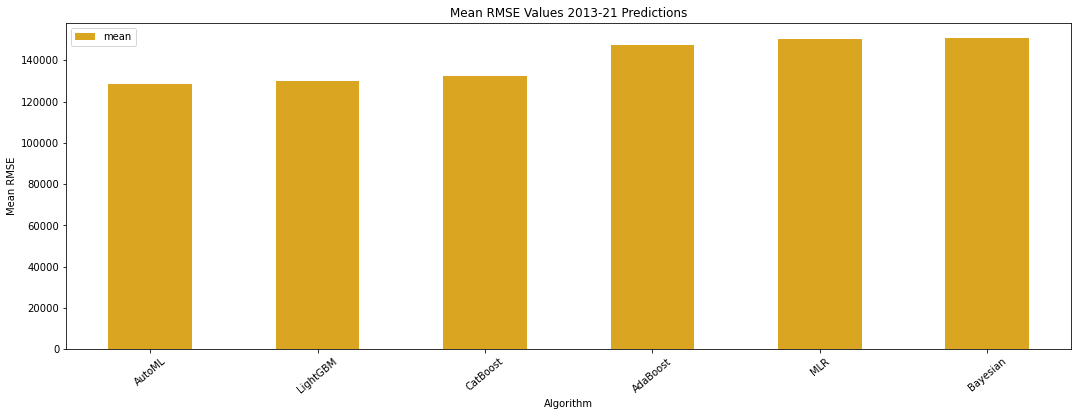

In [270]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Mean RMSE', title='Mean RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MEDAE'>

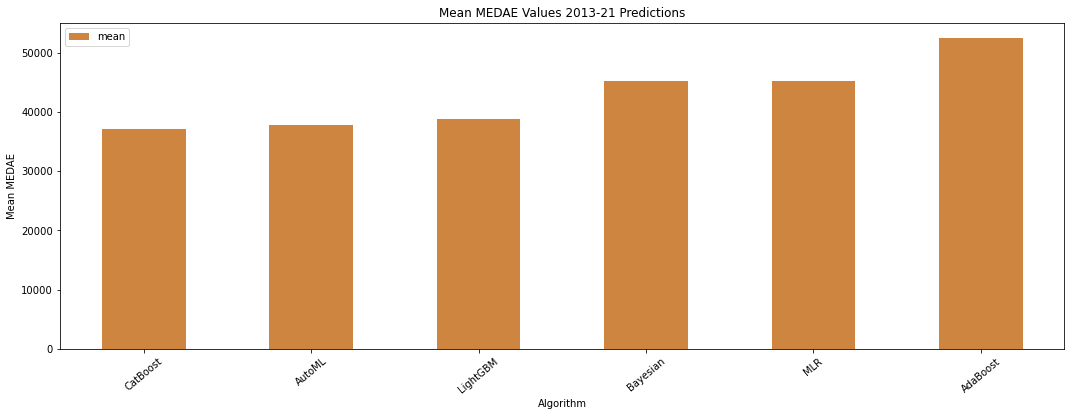

In [271]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Mean MEDAE', title='Mean MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

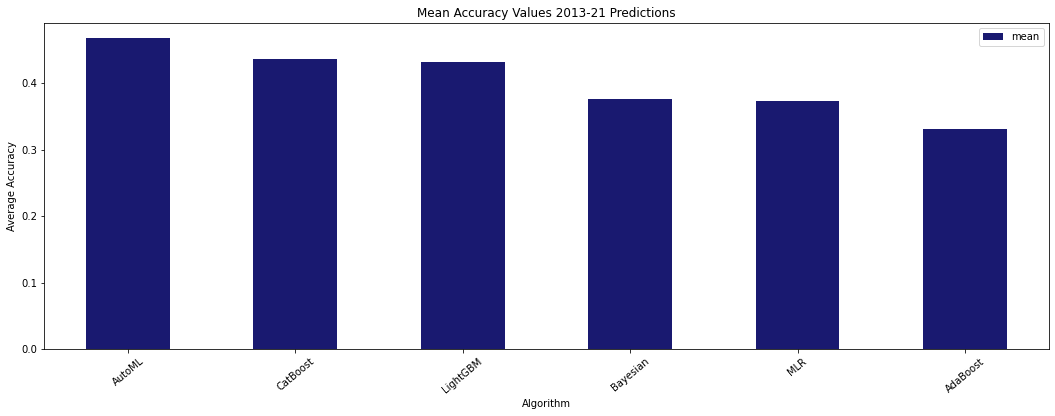

In [272]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum', 'min']})
grouped_multiple3.columns = ['mean','median','max','sum', 'min']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MSE'>

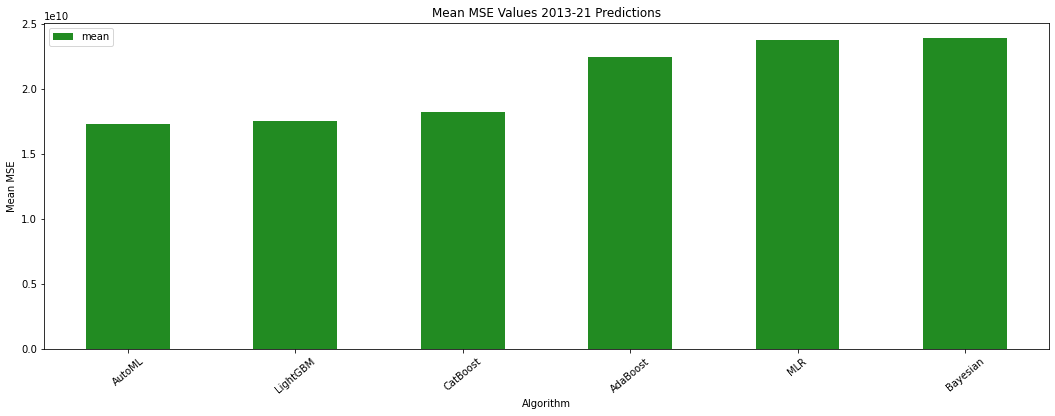

In [273]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Mean MSE', title='Mean MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

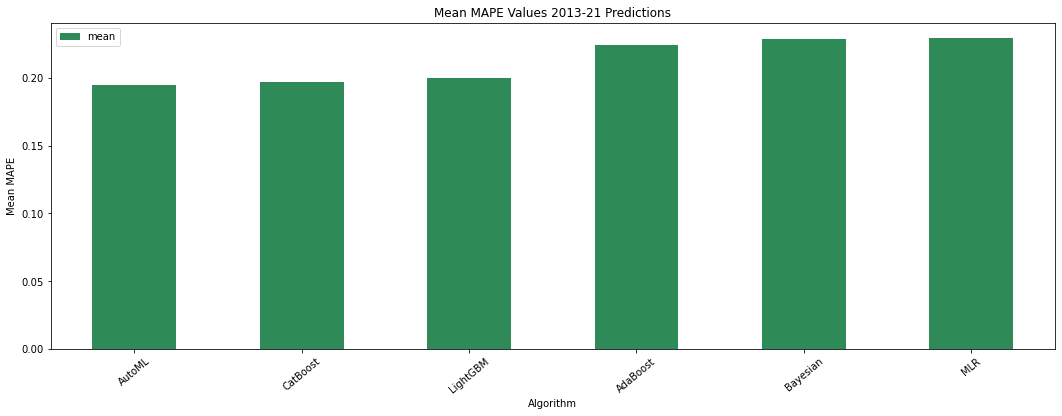

In [274]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

Result that can be compared around 6/7 % off [this](https://arxiv.org/pdf/2108.09175.pdf), (slightly diff approach taken by me predicting yearly however!)

In [275]:
grouped_multiple3.sort_values(by = 'mean', ascending = False)

,Algorithm,mean,median,max,sum,min
1,AutoML,0.466840,0.473618,0.547049,2.334199,0.382979
3,CatBoost,0.435812,0.456853,0.496013,2.179061,0.310638
4,LightGBM,0.431318,0.453469,0.505582,2.156590,0.340426
2,Bayesian,0.376323,0.370016,0.443316,1.881616,0.314894
5,MLR,0.373033,0.371611,0.426396,1.865164,0.306383
0,AdaBoost,0.330652,0.326276,0.385965,1.653262,0.297872


<AxesSubplot:title={'center':'Performance of ML algorithms accuracy from 2017-2021 Predictions'}, xlabel='Year'>

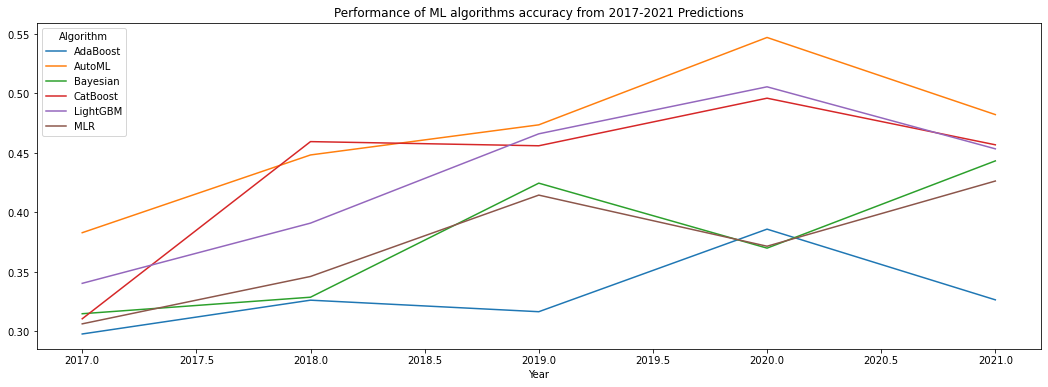

In [276]:
# yearly accuracy results
df = vis2.pivot(index = 'Year', columns = 'Algorithm', values = 'Accuracy')
df.plot(figsize = (18, 6), title = 'Performance of ML algorithms accuracy from 2017-2021 Predictions')

It is definitely worth noting the steep rise in performance of our prediction models after 2018. Looking at our AutoML approach in particular this sees a jump of 10% in predictive performance from 2018 to 2019 and remains well above 2017 and 2018 performance values. Looking across the board it definitely seems that our models are better suited to more up to date data, which is definitely a good thing. It may also suggest that the importance of our features changes noticeably over time with features such as closeness to parks and so forth maybe appearing more favourably in the midst of the global pandemic from 2020 onwards.

### Let's plot our Actual VS Predicted values for our best model - AutoML

In [277]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index=True)

In [278]:
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,12.624668
1,12.747268
2,13.072690
3,12.797276
4,12.653239


In [279]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index=True)

In [280]:
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.659390
1,12.669011
2,12.488560
3,12.718362
4,12.669011


In [281]:
actualvpred = actual.join(pred)

In [282]:
actualvpred.head()

,Actual,Predicted
0,12.624668,12.659390
1,12.747268,12.669011
2,13.072690,12.488560
3,12.797276,12.718362
4,12.653239,12.669011


In [283]:
# actual prices for better plot
exp = np.exp(actualvpred)

In [284]:
exp.shape

(3287, 2)

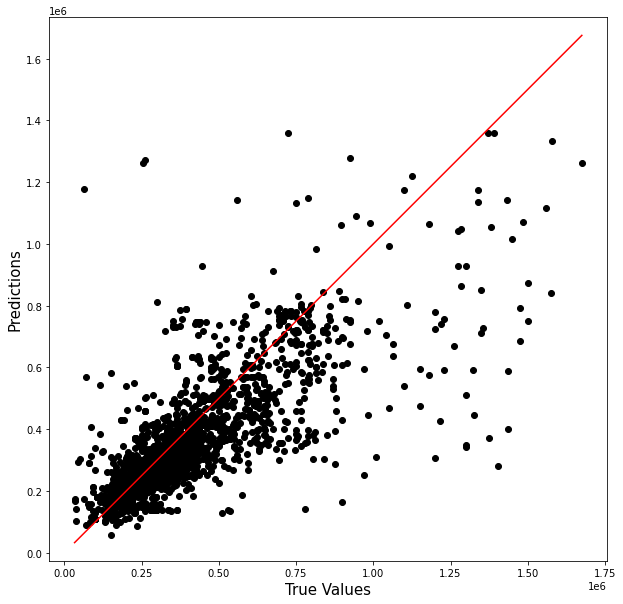

In [285]:
# plot predicted vs actual
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'black')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'r-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

### Predictions and True Values Evaluation

Our model is certainly most accurate between the 250,000€ to ~600,000€ range. There is definitely far more outliers as we increase our true values to around the 1,000,000€ mark. Some of these more expensive properties are definitely accurate (2 of note around 1.75m mark) but definitely we see it more accurate at the lower / average end of values. 

### Let's plot locations of our Properties and Accuracy of our results

In [286]:
import geopandas as gpd
ROI_map = gpd.read_file('counties\counties.shp')  #reading the shape file for our maps 
ROI_map.head(1)

2022-04-26 11:15:50,932 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.
2022-04-26 11:15:50,934 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


,OSM_ID,NAME_TAG,NAME_GA,NAME_EN,ALT_NAME,ALT_NAME_G,LOGAINM_RE,OSM_USER,OSM_TIMEST,ATTRIBUTIO,T_IE_URL,AREA,LATITUDE,LONGITUDE,EPOCH_TSTM,geometry
0,-338539.0,Mayo,Contae Mhaigh Eo,County Mayo,None,None,100023,Polarbear,2009-11-28 21:59:01+01,None,http://www.townlands.ie/mayo,5.596522e+09,53.924239,-9.385225,1.259442e+09,"MULTIPOLYGON (((-10.13689 54.10969, -10.13601 ..."


In [287]:
dub = ROI_map.loc[ROI_map['NAME_TAG'] == 'Dublin']
dub

,OSM_ID,NAME_TAG,NAME_GA,NAME_EN,ALT_NAME,ALT_NAME_G,LOGAINM_RE,OSM_USER,OSM_TIMEST,ATTRIBUTIO,T_IE_URL,AREA,LATITUDE,LONGITUDE,EPOCH_TSTM,geometry
23,-282800.0,Dublin,Contae Ãtha Cliath,County Dublin,None,None,100002,mackerski,2009-10-07 01:32:34+02,None,http://www.townlands.ie/dublin,9.290204e+08,53.392222,-6.283976,1.254872e+09,"MULTIPOLYGON (((-6.54689 53.27948, -6.54642 53..."


In [288]:
dub1 = dub[['NAME_TAG', 'LATITUDE', 'LONGITUDE', 'geometry']]

In [289]:
irl['ActualPrice'] = np.exp(irl['LogPrice (€)'])

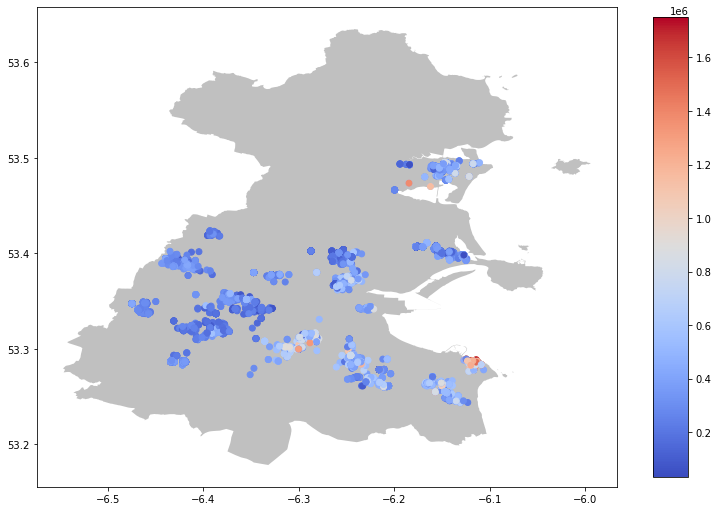

In [290]:
fig, ax = plt.subplots(figsize = (13, 13))
# O'Connell St. lat is 53.34975, and the longitude is -6.260113
dub1.plot(ax = ax, color = 'silver')
#ax.axhline(y = 53.34975, color='r', linestyle = '--')
plt.scatter(x = irl['Longitude'], y = irl['Latitude'], c = irl['ActualPrice'], cmap = 'coolwarm')
#plt.title('Plot of the Locations of Properties used in the Dublin dataset')
plt.colorbar(shrink = 0.65, aspect = 20*0.65)
plt.show()

#fig.savefig('dublindataset-prices-area.png')

### Location of Accurate VS Inaccurate

In [291]:
l1 = dfreal1.join(x_test_21[['Longitude', 'Latitude']])
l2 = dfreal2.join(x_test_20[['Longitude', 'Latitude']])
l3 = dfreal3.join(x_test_19[['Longitude', 'Latitude']])
l4 = dfreal4.join(x_test_18[['Longitude', 'Latitude']])
l5 = dfreal5.join(x_test_17[['Longitude', 'Latitude']])

In [292]:
plots = pd.concat([l1, l2, l3, l4, l5], ignore_index=True)

In [293]:
plots.rename(columns = {0 : 'Actual'}, inplace = True)

In [294]:
plotscomp = plots.join(pred)
plotscomp.head()

,Actual,Longitude,Latitude,Predicted
0,12.624668,-6.433316,53.287576,12.659390
1,12.747268,-6.434182,53.286440,12.669011
2,13.072690,-6.127101,53.397993,12.488560
3,12.797276,-6.154503,53.404602,12.718362
4,12.653239,-6.434182,53.286440,12.669011


In [295]:
exp1 = np.exp(plotscomp[['Actual', 'Predicted']])

In [296]:
exp1 = exp1.join(plotscomp[['Longitude', 'Latitude']])

In [297]:
exp1.head()

,Actual,Predicted,Longitude,Latitude
0,303965.0,314704.748411,-6.433316,53.287576
1,343612.0,317747.235834,-6.434182,53.286440
2,475770.0,265285.010587,-6.127101,53.397993
3,361232.0,333821.641915,-6.154503,53.404602
4,312775.0,317747.235834,-6.434182,53.286440


In [298]:
num = 0.1
lst = []
test = np.array(exp1['Actual'])
pred = np.array(exp1['Predicted'])
count = 0
for i in range(len(pred)):
    if test[i] != 0:  
        ten = test[i] * num
        res = test[i] - pred[i]
    else:
        res = 0
        ten = 0
        
    if res < 0:
        res = res * -1
    else:
        res = res
            
    if res <= ten:
        lst.append(1)
    else:
        lst.append(0)

In [299]:
exp1['Accurate'] = lst

In [300]:
exp1.head()

,Actual,Predicted,Longitude,Latitude,Accurate
0,303965.0,314704.748411,-6.433316,53.287576,1
1,343612.0,317747.235834,-6.434182,53.286440,1
2,475770.0,265285.010587,-6.127101,53.397993,0
3,361232.0,333821.641915,-6.154503,53.404602,1
4,312775.0,317747.235834,-6.434182,53.286440,1


In [301]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap1 = ListedColormap(["red", "limegreen"])

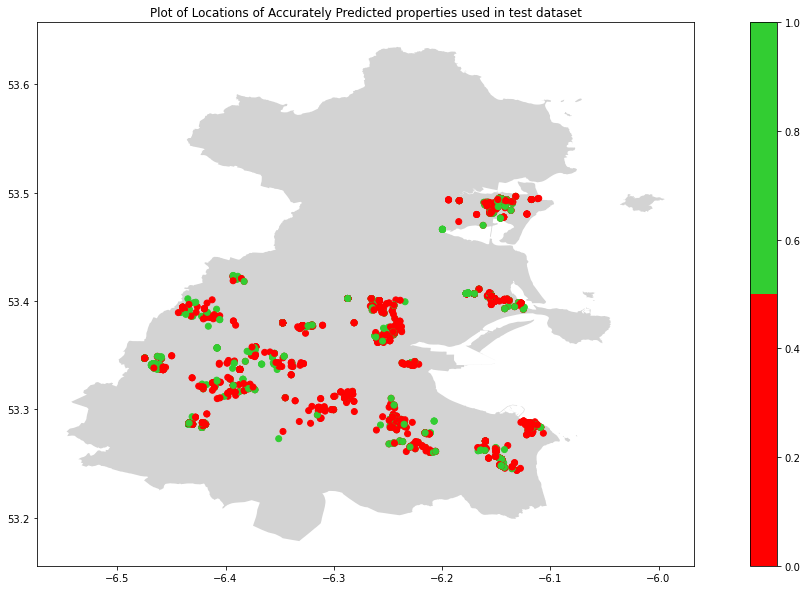

In [302]:
### RED = accurate , BLUE = Inaccurate
fig, ax = plt.subplots(figsize = (20, 10))
# O'Connell St. lat is 53.34975, and the longitude is -6.260113
dub1.plot(ax = ax, color = 'lightgrey')
#ax.axhline(y = 53.34975, color = 'r', linestyle = '--')
plt.scatter(x = exp1['Longitude'], y = exp1['Latitude'], c = exp1['Accurate'], cmap = cmap1)
plt.title('Plot of Locations of Accurately Predicted properties used in test dataset')
plt.colorbar()
plt.show()

In [303]:
vis2

,Algorithm,Year,RMSE,MSE,MEDAE,Accuracy,MAPE
0,Bayesian,2020,146027.578822,2.132405e+10,45819.520516,0.370016,0.231073
1,Bayesian,2021,172695.076543,2.982359e+10,45861.682855,0.443316,0.205888
2,CatBoost,2020,121653.233455,1.479951e+10,32710.960724,0.496013,0.189314
3,CatBoost,2021,173731.364042,3.018259e+10,42165.950189,0.456853,0.205605
4,LightGBM,2021,171029.181699,2.925098e+10,42635.440585,0.453469,0.208744
5,LightGBM,2020,112540.771517,1.266543e+10,32830.893370,0.505582,0.174905
6,AdaBoost,2020,123929.103865,1.535842e+10,45584.375330,0.385965,0.197538
7,AdaBoost,2021,197825.424620,3.913490e+10,63613.457271,0.326565,0.246387
8,MLR,2020,145480.878542,2.116469e+10,45334.253354,0.371611,0.232927
9,MLR,2021,172699.760659,2.982521e+10,47041.711718,0.426396,0.205911


In [310]:
valuess = vis2.groupby(['Algorithm']).mean()
#valuess.rename(columns={0: 'Averages'}, inplace = True)
valuess.style.format("{:.3f}")

,RMSE,MSE,MEDAE,Accuracy,MAPE
Algorithm,,,,,
AdaBoost,147314.624,22432446107.245,52364.821,0.331,0.224
AutoML,128734.047,17294662687.565,37786.147,0.467,0.194
Bayesian,150545.724,23860422726.719,45116.856,0.376,0.228
CatBoost,132601.203,18203563240.269,37183.148,0.436,0.197
LightGBM,129980.102,17549231893.545,38752.366,0.431,0.199
MLR,150171.308,23740024120.210,45189.113,0.373,0.229
